<a href="https://colab.research.google.com/github/haoweiiil/fake-news-classification/blob/main/Fake_news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File Import and Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [ ]:
! unzip '/content/drive/MyDrive/CIS520/Final project/Fake.csv.zip'
! unzip '/content/drive/MyDrive/CIS520/Final project/True.csv.zip'

Archive:  /content/drive/MyDrive/CIS520/Final project/Fake.csv.zip
  inflating: Fake.csv                
Archive:  /content/drive/MyDrive/CIS520/Final project/True.csv.zip
  inflating: True.csv                


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split

# Preprocessing and Visualization

In [ ]:
fake_df=pd.read_csv('Fake.csv')
fake_df['label'] = pd.Series(['fake']*len(fake_df))
true_df = pd.read_csv('True.csv')
true_df['label'] = pd.Series(['real']*len(true_df))

In [ ]:
fake_df[fake_df['subject']=='News'].head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [ ]:
fake_df['subject'].value_counts()

News               9050
politics           6435
left-news          4310
Government News    1499
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [ ]:
fake_df.title[18]

' SNL Hilariously Mocks Accused Child Molester Roy Moore For Losing AL Senate Race (VIDEO)'

In [ ]:
true_df['subject'].value_counts()

politicsNews    11271
worldnews       10145
Name: subject, dtype: int64

## Cleaning text field


1.   Remove "Reuters" tag from true news text, since all true news were extracted from Reuters
2.   Remove source link in real news
3.   Remove "Photo by ..." in fake news.
4.   Remove entries with empty text.



In [ ]:
# remove reuters tag from real news text
import re
def clean_txt(txt):
  # remove reuters
  # txt = re.sub('^[A-Z]*\/?[A-Z]*( ){0,1}\(Reuters\)( - )?|\(Reuters\)', '', txt)
  if (len(re.findall('\(Reuters\) - ', txt))>0) & (len(txt.split(' - ',1)) > 1):
    txt = txt.split(' - ',1)[1]

  #remove source url at then end
  txt = re.sub('( -- )?Source link: .+$', '', txt)
  
  return txt

true_df['text'] = true_df['text'].apply(lambda x: clean_txt(x))

# strip whitespace in date column
true_df['date'] = true_df['date'].apply(lambda x: x.strip())

# remove entries without text
true_df = true_df[true_df['text']!=' ']

In [ ]:
# remove photo tag from fake news text
def remove_photo(txt):
  if re.search('Photo by .+|Featured image |Flame image by',txt):
    txt = re.sub('Photo by (.)+$|Featured image (.)+$|Flame image by (.)+$', '',txt)
  return txt

fake_df['text'] = fake_df['text'].apply(lambda x: remove_photo(x))

# remove entries without text
fake_df = fake_df[fake_df['text']!=' ']

# Remove (VIDEOS) tag in fake news titles
fake_df['title'] = fake_df['title'].apply(lambda x: re.sub('\(Video\)|(\(|\[)(.)*VIDEO(S)?(.)*(\)|\])|^(.)*VIDEO:','',x))

In [ ]:
fake_df['subject'].value_counts()

News               9050
politics           6435
left-news          4310
Government News    1499
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [ ]:
true_df.subject.value_counts()

politicsNews    11271
worldnews       10145
Name: subject, dtype: int64

In [ ]:
fake_df.title[5]

' Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs (GRAPHIC IMAGES)'

In [ ]:
true_df.title[7]

'White House, Congress prepare for talks on spending, immigration'

## Combining false and real news dataset

In [ ]:
combined_df = fake_df.append(true_df, ignore_index = True)

## I. Date Patterns

In [ ]:
# parse date
def validate(date):
  for fmt in ('%B %d, %Y', '%d-%b-%y', '%b %d, %Y'):
    try:
      return datetime.strptime(date, fmt)
    except ValueError:
      return None
combined_df['date'] = combined_df['date'].apply(lambda x: validate(x))

# extract day of week
combined_df['dow'] = combined_df['date'].apply(lambda x: x.isoweekday())
# extract month
combined_df['month'] = combined_df['date'].apply(lambda x: x.month)
# extract year
combined_df['year'] = combined_df['date'].apply(lambda x: x.year)

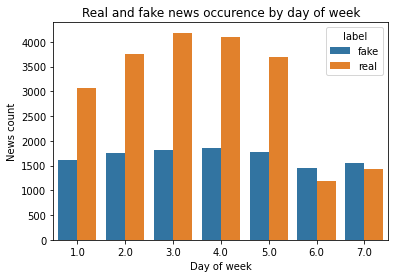

In [ ]:
plt.title('Real and fake news occurence by day of week')
sns.countplot(data=combined_df, x='dow', hue='label')
plt.xlabel('Day of week')
plt.ylabel('News count')
plt.show()

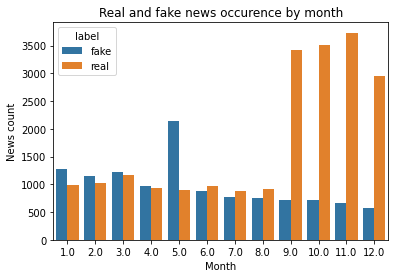

In [ ]:
plt.title('Real and fake news occurence by month')
fig = sns.countplot(data=combined_df, x='month', hue='label')
plt.xlabel('Month')
plt.ylabel('News count')
plt.show()

**Note:**
It doesn't make intuitive sense that there are more real news in 2017. We think this could merely be an outcome of data collection method. Therefore for future adaptability, we are not going to include year variable here, even though it might be a good predictor in our data.

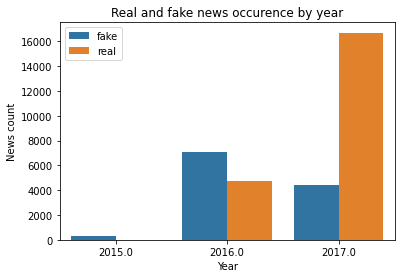

In [ ]:
plt.title('Real and fake news occurence by year')
sns.countplot(data=combined_df, x='year', hue='label')
plt.xlabel('Year')
plt.ylabel('News count')
plt.legend(loc='upper left')
plt.show()


In [ ]:
# convert news label to binary variable
# 1 if fake news
combined_df['label'] = combined_df['label'].apply(lambda x: 1*(x=='fake'))

## Additional step: Create dataset with a subset of subjects

In [ ]:
def select_subjects(subject, label):
  if (label == 1) & (subject in ['politics', 'Government News']):
    return True
  if (label == 0) & (subject =='politicsNews'):
    return True 
  return False

# select politics related news
combined_df_subset = combined_df.copy()
combined_df_subset['keep_subject'] = combined_df_subset[['subject', 'label']].apply(lambda x: select_subjects(x[0], x[1]), axis=1)
combined_df_subset = combined_df_subset[combined_df_subset['keep_subject']==True]  

# keep only feature and label columns
combined_df_subset = combined_df_subset.reset_index(drop=True).drop(columns = ['subject', 'date', 'year', 'keep_subject'])

In [ ]:
combined_df_subset.shape

(19205, 5)

## Split train and test data

In [ ]:
# Drop irrelevant variables
combined_df = combined_df.drop(columns=['subject', 'date', 'year'])
combined_df.to_csv('/content/drive/MyDrive/CIS520/Final project/combined_df_cleaned.csv', index=False)

In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/CIS520/Final project/combined_df_cleaned.csv')

In [ ]:
# all data
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(combined_df.drop(columns='label'), combined_df['label'], test_size = 0.2, random_state = 47)

# subject subset
# X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(combined_df_subset.drop(columns='label'), combined_df_subset['label'], test_size = 0.2, random_state = 47)

### Impute missing date

In [ ]:
from sklearn.impute import SimpleImputer

# Fill missing day of week and month with median training date value
def impute_missing(X_train_df, X_test_df):
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
  imp_mean.fit(X_train_df[['dow','month']])
  X_train_df[['dow','month']] = imp_mean.transform(X_train_df[['dow','month']])
  X_test_df[['dow','month']] = imp_mean.transform(X_test_df[['dow','month']])

  return X_train_df, X_test_df

X_train_df, X_test_df = impute_missing(X_train_df, X_test_df)
# X_train_sub, X_test_sub = impute_missing(X_train_sub, X_test_sub)

## II. Term frequency in Title

Potential hyperparameter tuning:

1.   Number of word tokens to include in text vectorizer
2.   n-gram choice



### Punctuations

In [ ]:
# Any difference between usage of exclamation marks
combined_df['exm_count'] = combined_df['text'].apply(lambda x: x.count('!'))

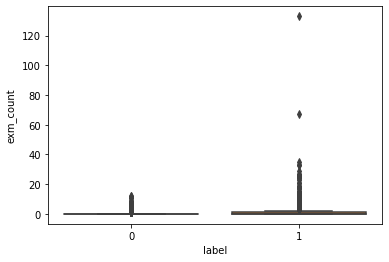

In [ ]:
sns.boxplot(data=combined_df,x='label', y='exm_count')

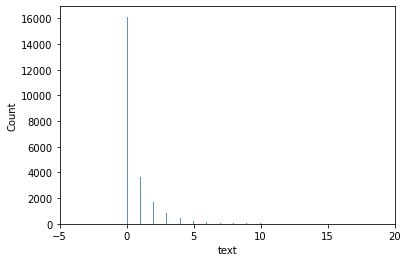

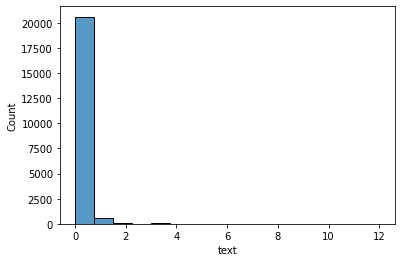

In [ ]:
# exclude outliers
sns.histplot(fake_exm_count)
plt.xlim(-5,20)
plt.show()

sns.histplot(real_exm_count)

### Explore the most frequent words in fake and real news

Keywords in fake new title


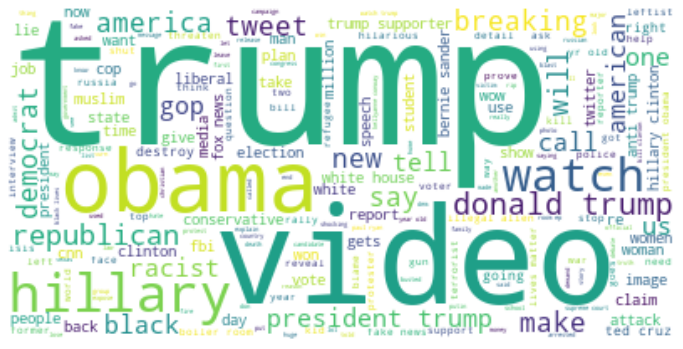

In [ ]:
# word frequency for fake news title
fake_title = fake_df.title.apply(lambda x: x.lower())

stopwords = set(STOPWORDS)
fake_titles = ' '.join(t for t in fake_title)
fake_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(fake_titles)
print("Keywords in fake new title")
plt.figure(figsize=(12,8))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Keywords in fake news text


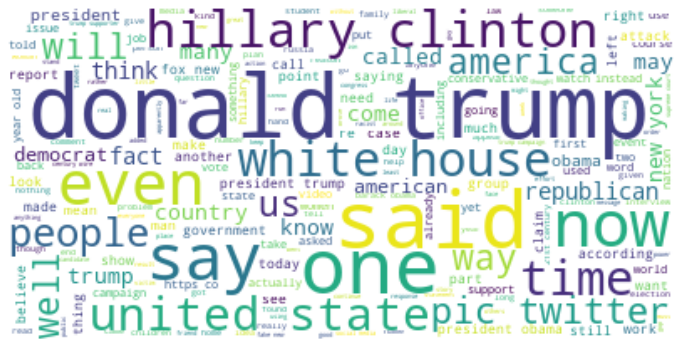

In [ ]:
# word frequency for fake news text
fake_text = fake_df.text.apply(lambda x: x.lower())

fake_text = ' '.join((t for t in fake_text))
fake_text_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(fake_text)
print("Keywords in fake news text")
plt.figure(figsize=(12,8))
plt.imshow(fake_text_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Keywords in true new title


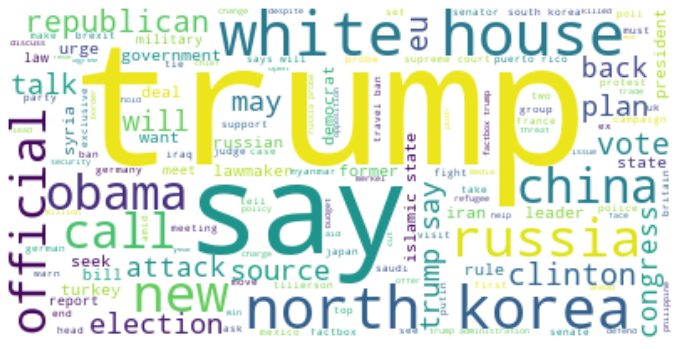

In [ ]:
# word frequency for true news title
true_titles = true_df.title.apply(lambda x: x.lower())

true_titles = ' '.join(t for t in true_titles)
true_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(true_titles)
print("Keywords in true new title")
plt.figure(figsize=(12,8))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Keywords in true news text


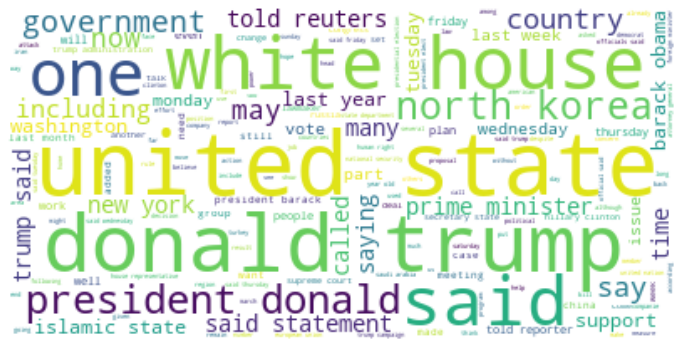

In [ ]:
# word frequency for true news text
true_text = true_df.text.apply(lambda x: x.lower())

true_text = ' '.join(t for t in true_text)
true_text_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(true_text)
print("Keywords in true news text")
plt.figure(figsize=(12,8))
plt.imshow(true_text_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### TF-IDF vectorization

#### Fit the training data and transform test data

In [ ]:
# Number of vocabularies to consider in title and text processing
title_features = 1000
text_features = 5000

def combine_vec(title_vec, text_vec, org_df):
  '''
  combine transformed title, text vectors with the rest of features
  '''
  date_vec = org_df.drop(columns = ['title', 'text']).values
  result_vec = np.hstack((title_vec, text_vec, date_vec))
  return result_vec

def tfidf_preprocess(X_train_df, X_test_df, y_train_df, y_test_df, title_feature=1000, text_features=5000):
  '''
  fit TF-IDF to training data and transform test/val data,
  title and text are vectorized separately

  return: x_train, x_test, y_train, y_test
  '''
  # fit vectorizer
  title_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), token_pattern=r'[a-zA-Z]+', max_features=title_features)
  text_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), token_pattern=r'[a-zA-Z]+', max_features=text_features)
  
  title_vec = title_vectorizer.fit_transform(X_train_df['title']).todense()
  text_vec = text_vectorizer.fit_transform(X_train_df['text']).todense()

  # convert training data
  x_train = combine_vec(title_vec, text_vec, X_train_df)
  y_train = y_train_df.values

  # transform test data
  test_title = title_vectorizer.transform(X_test_df['title']).todense()
  test_text = text_vectorizer.transform(X_test_df['text']).todense()
  x_test = combine_vec(test_title, test_text, X_test_df)
  y_test = y_test_df.values

  return x_train, x_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = tfidf_preprocess(X_train_df, X_test_df, y_train_df, y_test_df)

#### Apply PCA to word vectors (subject to change)

In [ ]:
def pca_convert(X_train, X_test, num_components = 750):
  '''
  Perform singular value decomposition on training data,
  transform and return both training and test features

  returns: z_train, z_test, s
  '''
  u,s,v = np.linalg.svd(X_train, full_matrices=False)
  vk = v.T[:,:num_components]
  z_train = X_train@vk
  z_test = X_test@vk

  return z_train, z_test, s

In [ ]:
u,s,v = np.linalg.svd(X_train, full_matrices=False)

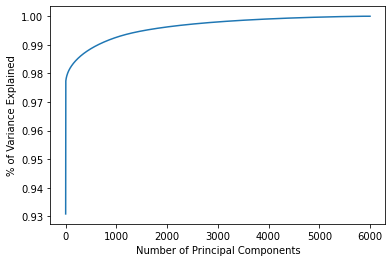

In [ ]:
eig_vals = s**2
explained_ratios = np.cumsum(eig_vals)/sum(eig_vals)
plt.plot(explained_ratios)
plt.xlabel('Number of Principal Components')
plt.ylabel('% of Variance Explained')
plt.show()

In [ ]:
num_comp = 750
vk = v.T[:,:num_comp]
z_train = X_train@vk
x_hat = z_train@vk.T
z_test = X_test@vk

print("variance explained by first ", str(num_comp), " principal components: ", sum(s[:num_comp]**2)/sum(s**2))

variance explained by first  750  principal components:  0.9909359547629796


# Modeling and Prediction

## Create validation set

In [ ]:
X_t, X_val, y_t, y_val = train_test_split(X_train_df, y_train_df, random_state=47)

In [ ]:
X_t, X_val, y_t, y_val = tfidf_preprocess(X_t, X_val, y_t, y_val)

In [ ]:
X_t, X_val, _ = pca_convert(X_t, X_val)

## I. Logistic regression (baseline)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

# regularization parameters

# parameters = {'C': [1,0.7], 'l1_ratio': [0.3, 0.5, 0.8]}

reg_param = 0.7 #regularization strength
l1_ratio = 0.8 #elastic net - l1 to l2 ratio

# fit training
clf = LogisticRegression(penalty='elasticnet', C = reg_param, l1_ratio = l1_ratio, solver='saga', max_iter=200)
# clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

# predictions
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# evaluation: accuracy 
print("training accuracy: ", accuracy_score(train_pred, y_train))
print("validation accuracy: ", accuracy_score(test_pred, y_test))
print("*********************************")

# evaluation: logistic loss
train_pred_prob = clf.predict_proba(X_train)
test_pred_prob = clf.predict_proba(X_test)
print("training logistic loss: ", log_loss(y_train, train_pred_prob))
print("validation logistic loss: ", log_loss(y_test, test_pred_prob))

# confusion matrix
print("validation confusion matrix")
confusion_matrix(y_test, test_pred)


In [ ]:
def search_lr(X_train, X_test, y_train, y_test, reg_param):
  # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47)

  # z_train, z_test = pca_convert(X_train, X_test)

  clf = LogisticRegression(penalty='elasticnet', C = reg_param, l1_ratio = 0.5, solver='saga', max_iter=600)
  clf.fit(X_train, y_train)

  # predictions
  train_pred = clf.predict(X_train)
  test_pred = clf.predict(X_test)

  # evaluation: accuracy 
  print("C: ", reg_param)
  print("training accuracy: ", accuracy_score(train_pred, y_train))
  print("validation accuracy: ", accuracy_score(test_pred, y_test))

  return clf

In [ ]:
for c in np.arange(0.8, 1.3, 0.1):
  search_lr(X_t, X_val, y_t, y_val, c)

C:  0.8
training accuracy:  0.9850914840749944
validation accuracy:  0.9811384684888186
C:  0.9
training accuracy:  0.985543257284843
validation accuracy:  0.981364355093743
C:  1.0
training accuracy:  0.9860703260296665
validation accuracy:  0.9814772983962051
C:  1.1
training accuracy:  0.9868232813794142
validation accuracy:  0.9819290716060538
C:  1.2
training accuracy:  0.9870868157518259
validation accuracy:  0.9826067314208268


In [ ]:
lr_final = LogisticRegression(penalty='elasticnet', C = 1.2, l1_ratio = 0.5, solver='saga', max_iter=600)
lr_final.fit(z_train, y_train)

print("Training accuracy: ", lr_final.score(z_train, y_train))
print("Test accuracy: ", lr_final.score(z_test, y_test))


Training accuracy:  0.9873785859498532
Test accuracy:  0.9820440429136081


In [ ]:
lr_final = LogisticRegression(penalty='elasticnet', C = 0.9, l1_ratio = 0.5, solver='saga', max_iter=600)
lr_final.fit(z_train, y_train)

print("Training accuracy: ", lr_final.score(z_train, y_train))
print("Test accuracy: ", lr_final.score(z_test, y_test))


Training accuracy:  0.9866162186582336
Test accuracy:  0.9813664596273292


**TODO**: briefly summarize logistic regression finding. \\

* quite surprising to have such a good performance given this simple model
* importance of regularization





### 1.1 Sensitivity test: importance of date

Our features generally fall in two categories: news content and date. We are curious whether published date information is important in our prediction accuracy.

In [ ]:
# only include text vectors
X_train_nodate = X_train[:,:-2]
X_test_nodate = X_test[:,:-2]

# fit training
lr2 = LogisticRegression(penalty='elasticnet', C=reg_param, solver='saga', l1_ratio=l1_ratio)
lr2.fit(X_train_nodate, y_train)

# predictions
train_pred = lr2.predict(X_train_nodate)
test_pred = lr2.predict(X_test_nodate)

# evaluation: accuracy 
print("training accuracy: ", accuracy_score(train_pred, y_train))
print("validation accuracy: ", accuracy_score(test_pred, y_test))
print("*********************************")

training accuracy:  0.9893157931370502
validation accuracy:  0.9866369710467706
*********************************


### 1.2 Subset of subjects

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

# regularization parameters

# parameters = {'C': [1,0.7], 'l1_ratio': [0.3, 0.5, 0.8]}

reg_param = 0.7 #regularization strength
l1_ratio = 0.8 #elastic net - l1 to l2 ratio

# fit training
clf = LogisticRegression(penalty='elasticnet', C = reg_param, l1_ratio = l1_ratio, solver='saga', max_iter=200)
# clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

# predictions
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

# evaluation: accuracy 
print("training accuracy: ", accuracy_score(train_pred, y_train))
print("validation accuracy: ", accuracy_score(test_pred, y_test))
print("*********************************")

# evaluation: logistic loss
train_pred_prob = clf.predict_proba(X_train)
test_pred_prob = clf.predict_proba(X_test)
print("training logistic loss: ", log_loss(y_train, train_pred_prob))
print("validation logistic loss: ", log_loss(y_test, test_pred_prob))

# confusion matrix
print("validation confusion matrix")
confusion_matrix(y_test, test_pred)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


training accuracy:  0.9825987552394259
validation accuracy:  0.9773939547879096
*********************************
training logistic loss:  0.07978444747370254
validation logistic loss:  0.08942187554064623
validation confusion matrix


array([[2254,   25],
       [  64, 1594]])

In [ ]:
# PCA transformed features
print("Logistic Regression with PCA transformed features")
lr = LogisticRegression(max_iter=200, solver='saga')
lr.fit(z, y_train)

print("training accuracy: ", lr.score(z, y_train))
from sklearn.metrics import f1_score
print("training F1: ", f1_score(y_train, lr.predict(z)))

print("test accuracy: ",lr.score(z_test, y_test))
print("test F1: ", f1_score(y_test, lr.predict(z_test)))


Logistic Regression with PCA transformed features
training accuracy:  0.9862822304077226
training F1:  0.983930962654367
test accuracy:  0.9776479552959106
test F1:  0.9732034104750305


## II. Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
train_pred = mnb.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print("Training accuracy with Naive Bayes: ", train_acc)
print('-------------------------------------------------')

test_pred = mnb.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print("Test accuracy with Naive Bayes: ", test_acc)

Training accuracy with Naive Bayes:  0.9564968880985647
-------------------------------------------------
Test accuracy with Naive Bayes:  0.9484378968757937


## III. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train)

In [ ]:
rf = RandomForestClassifier(n_estimators=300, max_depth=45, max_samples=0.9)
rf.fit(X_train2, y_train2)
print("Maximum depth: ", depth)
print("training accuracy: ", rf.score(X_train2, y_train2))
print("validation accuracy: ", rf.score(X_val, y_val))

Maximum depth:  100
training accuracy:  0.9999153188246253
validation accuracy:  0.984251968503937


In [ ]:
# with subject selection
for depth in [80,90,100]:
  rf = RandomForestClassifier(n_estimators=250, max_depth=depth, max_samples=0.9)
  rf.fit(X_train2, y_train2)
  print("Maximum depth: ", depth)
  print("training accuracy: ", rf.score(X_train2, y_train2))
  print("validation accuracy: ", rf.score(X_val, y_val))

Maximum depth:  80
training accuracy:  1.0
validation accuracy:  0.983743967487935
Maximum depth:  90
training accuracy:  1.0
validation accuracy:  0.982981965963932
Maximum depth:  100
training accuracy:  1.0
validation accuracy:  0.983743967487935


In [ ]:
for sample in [0.8,0.9]:
  for depth in [40,50,60]:
    rf = RandomForestClassifier(n_estimators=150, max_depth=depth, max_samples=sample)
    rf.fit(X_t, y_t)
    print("Maximum depth: ", depth)
    print("training accuracy: ", rf.score(X_t, y_t))
    print("validation accuracy: ", rf.score(X_val, y_val))

Maximum depth:  40
training accuracy:  0.9999247044650252
validation accuracy:  0.9609216173480912


## IV. Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

def fit_linear_svm(X_train, X_val, y_train, y_val, C, print_result = True):

  # split training and validation set
  # X = X_train.copy()
  # y = y_train.copy()
  # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 47)

  accuracy_list = []

  for c in C:
    lsvm = LinearSVC(C=c, dual=False, max_iter=2500)
    lsvm.fit(X_train , y_train)
    val_acc = lsvm.score(X_val, y_val)
    accuracy_list.append(val_acc)
    if print_result:
      print("Regularization parameter is: ", c)
      print("Linear SVM - training accuracy: ", lsvm.score(X_train, y_train))
      print("Linear SVM - validation accuracy: ", val_acc)

  # train the model again with the best hyperparameter
  accuracy_list = np.array(accuracy_list)
  best_c = C[np.argmax(accuracy_list)]
  best_lsvm = LinearSVC(C=best_c, dual=False, max_iter=2500)

  return best_lsvm, best_c 


In [ ]:
lsvm, best_c = fit_linear_svm(X_t, X_val, y_t, y_val, np.arange(0.8, 1.3, 0.1), True)
# print("Linear SVM - training accuracy: ", lsvm.score(z_train, y_train))
# print("Linear SVM - test accuracy: ", lsvm.score(z_test, y_test))

Regularization parameter is:  0.8
Linear SVM - training accuracy:  0.9913410134779007
Linear SVM - validation accuracy:  0.9846397108651457
Regularization parameter is:  0.9
Linear SVM - training accuracy:  0.9913786612453881
Linear SVM - validation accuracy:  0.9843008809577592
Regularization parameter is:  1.0
Linear SVM - training accuracy:  0.9916798433852873
Linear SVM - validation accuracy:  0.9845267675626835
Regularization parameter is:  1.1
Linear SVM - training accuracy:  0.9918304344552368
Linear SVM - validation accuracy:  0.9843008809577592
Regularization parameter is:  1.2
Linear SVM - training accuracy:  0.9920186732926738
Linear SVM - validation accuracy:  0.9846397108651457


# Streamline Modeling

This section will run the previously written functions for each model and compare the results. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
def modelEval(X_train, y_train, X_test, y_test, train_dict, test_dict, clf, model_name, print_result=False):
  clf.fit(X_train, y_train)

  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)

  train_dict[model_name] = train_score
  test_dict[model_name] = test_score

  if print_result:
    print(model_name, "- training accuracy: ",  train_score)
    print(model_name, "- test accuracy: ",  test_score)

  return train_dict, test_dict, clf

## I. Full dataset

In [ ]:
X_train, X_test, y_train, y_test = tfidf_preprocess(X_train_df, X_test_df, y_train_df, y_test_df)

(35416, 6002)

In [ ]:
z_train, z_test, s= pca_convert(X_train, X_test)

In [ ]:
# initiate dictionary for accuracy recording
train_dict = {}
test_dict = {}

# logistic regression
lr = LogisticRegression(penalty='elasticnet', C = 1.2, l1_ratio = 0.5, solver='saga', max_iter=400)
train_dict, test_dict, lr = modelEval(z_train, y_train, z_test, y_test, train_dict, test_dict, lr, 'Logistic regression', True)

# Naive Bayes with pre-PCA features
mnb = MultinomialNB()
train_dict, test_dict, mnb = modelEval(X_train, y_train, X_test, y_test, train_dict, test_dict, mnb, 'Naive bayes', True)

# Random forest
rf = RandomForestClassifier(n_estimators=180, max_depth=50, max_samples=0.8)
train_dict, test_dict, rf = modelEval(z_train, y_train, z_test, y_test, train_dict, test_dict, rf, 'Random Forest', True)

# linear svm
lsvm = LinearSVC(C=0.8, dual=False, max_iter=2500)
train_dict, test_dict, lsvm = modelEval(z_train, y_train, z_test, y_test, train_dict, test_dict, lsvm, 'Linear SVM', True)

Linear SVM - training accuracy:  0.9904845267675627
Linear SVM - test accuracy:  0.9823828345567476


In [ ]:
print(test_dict)

{'Logistic regression': 0.9819311123658949, 'Naive bayes': 0.9455674760022587, 'Random Forest': 0.9626199887069452, 'Linear SVM': 0.9823828345567476}


### Inspect the wrong classifications

In [ ]:
# linear regression
from sklearn.metrics import confusion_matrix
y_pred = lr.predict(z_test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[4233,   85],
       [  89, 4448]])

In [ ]:
# false negatives index
np.where((y_test==1) & (y_pred==0))

(array([  17,  104,  111,  265,  403,  635,  694,  759,  795,  827,  901,
        1027, 1041, 1342, 1400, 1436, 1465, 1555, 1630, 1786, 1874, 2052,
        2276, 2308, 2335, 2380, 2549, 2603, 2607, 2818, 2865, 2882, 2914,
        2945, 2955, 3261, 3299, 3441, 3549, 3582, 3650, 3862, 4211, 4218,
        4272, 4320, 4466, 4520, 4525, 4622, 4643, 4775, 4795, 5118, 5370,
        5374, 5380, 5406, 5500, 5586, 5618, 5856, 6041, 6550, 6638, 6692,
        6789, 7293, 7367, 7379, 7407, 7836, 7916, 7936, 8046, 8058, 8060,
        8117, 8133, 8150, 8182, 8323, 8425, 8464, 8481, 8553, 8627, 8709,
        8839]),)

In [ ]:
# Examples of false negative
X_test_df.reset_index(drop=True).iloc[111].text

'The Wall Street Journal reported on Friday that Tillerson was leading the field after former Mayor Rudy Giuliani took his name out of the running for the job. New York Times reporter Maggie Haberman reported that Tillerson was expected to meet with Trump today.- BreitbartThe 64-year-old veteran oil executive has no government or diplomatic experience, although he has ties to Russian President Vladimir Putin. The pick would put to rest weeks-long speculation of who would earn the post as the U.S. s top diplomat, and would place Tillerson fourth in line to the presidency.He will also be paired with former U.N. Ambassador John Bolton as his deputy secretary of state, one of the sources added, with Bolton handling day-to-day management of the department.  NBCTillerson is a surprising choice, particularly for establishment political forces who urged Trump to select Mitt Romney for the job. Romney signaled interest in the position, appearing publicly to recant his opposition to the presiden

In [ ]:
# False positive index
np.where((y_test==0) & (y_pred==1))

(array([ 272,  283,  473,  620,  654,  758,  796,  989, 1084, 1094, 1095,
        1221, 1238, 1397, 1481, 1558, 1593, 1600, 1718, 1810, 1827, 1976,
        1979, 1982, 2005, 2169, 2190, 2494, 2622, 2772, 2840, 2910, 3062,
        3192, 3376, 3464, 3646, 3704, 3950, 4079, 4174, 4239, 4438, 4531,
        4699, 4726, 4734, 4872, 4875, 4949, 4950, 4967, 5033, 5122, 5229,
        5309, 5364, 5541, 5584, 5619, 5783, 5793, 5806, 5807, 5924, 6030,
        6184, 6458, 6602, 6999, 7037, 7122, 7166, 7309, 7320, 7399, 7850,
        7886, 7891, 7990, 8110, 8165, 8432, 8475, 8488]),)

In [ ]:
# Examples of false positive
X_test_df.reset_index(drop=True).iloc[796].text

'Donald Trump Jr. was told prior to meeting a Russian lawyer whom he believed had information damaging to Hillary Clinton that the material was part of a Russian government effort to help his father’s presidential campaign, the New York Times reported on Monday, citing three people with knowledge of the email. Publicist Rob Goldstone, who helped broker the June 2016 meeting, sent the email to President Donald Trump’s eldest son, the Times said. Goldstone’s message indicates that the Russian government was the source of the potentially damaging information, according to the Times.  '

## II. Subset of subjects

In [ ]:
X_train2, X_test2, y_train2, y_test2 = tfidf_preprocess(X_train_sub, X_test_sub, y_train_sub, y_test_sub)

z_train2, z_test2, s2= pca_convert(X_train2, X_test2)


(35416, 750)

In [ ]:
# initiate dictionary for accuracy recording
train_dict_sub = {}
test_dict_sub = {}

# logistic regression
reg_param = 0.7 #regularization strength
l1_ratio = 0.8 #elastic net - l1 to l2 ratio
lr = LogisticRegression(penalty='elasticnet', C = reg_param, l1_ratio = l1_ratio, solver='saga', max_iter=250)
train_dict, test_dict, lr = modelEval(z_train2, y_train2, z_test2, y_test2, train_dict_sub, test_dict_sub, lr, 'Logistic regression', True)

# Naive Bayes with pre-PCA features
mnb = MultinomialNB()
train_dict, test_dict, mnb = modelEval(X_train2, y_train2, X_test2, y_test2, train_dict_sub, test_dict_sub, mnb, 'Naive bayes', True)

# Random forest
rf = RandomForestClassifier(n_estimators=180, max_depth=50, max_samples=0.8)
train_dict, test_dict, rf = modelEval(z_train2, y_train2, z_test2, y_test2, train_dict_sub, test_dict_sub, rf, 'Random Forest', True)

# linear svm
lsvm = LinearSVC(C=0.6, dual=False, max_iter=2500)
train_dict, test_dict, lsvm = modelEval(z_train2, y_train2, z_test2, y_test2, train_dict_sub, test_dict_sub, lsvm, 'Linear SVM', True)

Logistic regression - training accuracy:  0.9804087477219474
Logistic regression - test accuracy:  0.9776099973965113
Naive bayes - training accuracy:  0.9539833376724811
Naive bayes - test accuracy:  0.9476698776360323
Random Forest - training accuracy:  1.0
Random Forest - test accuracy:  0.975006508721687
Linear SVM - training accuracy:  0.9919291851080447
Linear SVM - test accuracy:  0.9809945326737829


In [ ]:
def modelEval(X, y, test_perc, model, result_output_name, path = "../model_results/"):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_perc, random_state=42)
  clf = model.fit(X_train, y_train)
  
  # predict
  y_pred_train = clf.predict(X_train)
  y_pred_test = clf.predict(X_test)
  assert(y_pred_train.shape == y_train.shape)
  assert(y_pred_test.shape == y_test.shape)
  
  # save results in dictionary
  model_dict = {}
  model_dict['train accuracy'] = clf.score(X_train, y_train)
  model_dict['test accuracy'] = clf.score(X_test, y_test)
  model_dict['train f-score'] = f1_score(y_train, y_pred_train)
  model_dict['test f-score'] = f1_score(y_test, y_pred_test)
  
  # output the dictionary
  with open(path + result_output_name + ".json", "w") as outfile:  
      json.dump(model_dict, outfile) 
  
  # print
  print('train accuracy:', model_dict['train accuracy'])
  print('test accuracy:', model_dict['test accuracy'])
  print('train f-score:', model_dict['train f-score'])
  print('test f-score:', model_dict['test f-score'])
  
  return clf, model_dict